In [50]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from grid import min_cost
%matplotlib inline
%run utils.py

In [50]:
chunks = pd.read_csv('data/yellow_tripdata_2009-01_train.csv', chunksize=100000)

In [51]:
h = True
for df in tqdm(chunks, total=93):
    df = rotate_manhattan(filter_manhattan(unnormalize(df)))
    df.to_csv('data/yellow_tripdata_2009-01_train_JC.csv', mode='a',
              index=False,
              header=h)
    h = False

/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_x'] = starts[:,0] + 84.125113
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start_y'] = starts[:,1] + 7.853407
/Users/jiafengchen/Documents/Junior/CS 281/final-project/utils.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [111]:
chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=1000)

In [ ]:
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD
from IPython.display import clear_output

grid = np.load('grid.npy')
gr = np.zeros((10,35))
for i, j in grid:
    gr[int(i), int(j)] = 1.0

weights = Variable(torch.from_numpy(1000*(1 - gr)).float(), requires_grad=True)
optimizer = SGD([weights], lr = 0.0001)

In [ ]:
num_epochs = 5
with tqdm(total=num_epochs * 8030 * 1000) as pbar:
    
    for epoch in range(num_epochs):
        chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', 
                             chunksize=1000)
        total_loss, n = 0, 0
        for df in chunks:
            for _, row in df.iterrows():
                pbar.update(1)
                source = (int(clip(round(row['start_x']), 0, 9)), 
                          int(clip(round(row['start_y']), 0, 34)))
                target = (int(clip(round(row['end_x']), 0, 9)), 
                          int(clip(round(row['end_y']), 0, 34)))
                path = min_cost(source, target, weights.data.numpy())
                pred = (Variable(Tensor(path)) * weights).sum()
                loss = (pred - row['duration']) ** 2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += np.sqrt(loss.data[0])
                n += 1
                if pbar.n % 500 == 0:
                    print(total_loss/n/60)
                    print(weights)
                    clear_output(wait=True)

3.34230563837
Variable containing:

Columns 0 to 6 
  977.8995   982.1036  1004.4904   989.6757   995.8461   993.2682   930.4995
  985.6401   976.5970   991.8770   989.1155   825.2278   -79.6456   -22.0291
   15.1782    -5.4795    13.3602   -22.3570   -12.8414   179.9811   110.5885
   33.6319    49.4283    87.4085    53.4945    72.8098    66.7509    82.0972
   78.1738   102.4325    80.5763    66.6623    80.1920    80.6834    86.7431
  -15.8002    28.3652    63.8500    82.3430    84.9106    96.7241    95.3037
   14.8373    -3.5092    40.3445    27.8502    92.5912   110.5331   112.2181
    6.3916   -30.9078   -22.5137    17.1099    49.8327    97.7316   119.5182
  999.6917   989.4030   924.3591   -37.9121     7.2790    58.3790    46.9034
 1000.0000  1000.0000  1000.0000   990.8253    -5.6151    15.7281    31.7345

Columns 7 to 13 
  -33.3714    11.6214    32.0045    67.5836    92.7670    74.1063    93.3665
   71.1320    98.2235    77.4954    40.9776   120.2633    76.9303    64.0757
  103.

In [131]:
cs = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=100000)

In [132]:
t = next(cs)

In [146]:
w = weights.data.numpy().copy()


In [157]:
w = weights.data.numpy().copy()
w[(w > 700)] = np.nan

(array([   2.,    0.,    3.,   12.,    9.,   37.,   75.,  139.,   20.,    1.]),
 array([-290.10040283, -240.25682678, -190.41325073, -140.56967468,
         -90.72609863,  -40.88252258,    8.96105347,   58.80462952,
         108.64820557,  158.49178162,  208.33535767]),
 <a list of 10 Patch objects>)

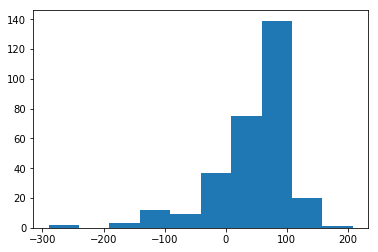

In [158]:
plt.hist((w[~np.isnan(w)]))

(-1.2025609488574673,
 12.767860741294614,
 -15.658745946636046,
 42.421876456482572)

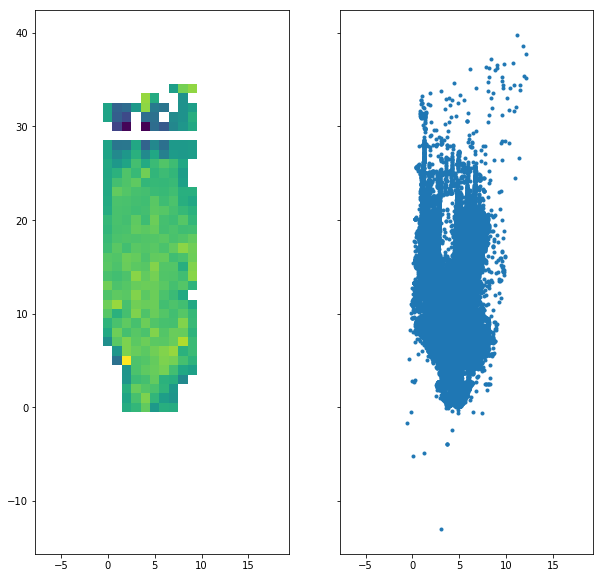

In [145]:
w = weights.data.numpy().copy()
w[(w > 400)] = np.nan
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10))
ax1.imshow(w.T/50,origin='lower')
ax2.plot(t['start_x'], t['start_y'], '.')
ax2.axis('equal')

In [144]:
w

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
          10.4303093 ,   33.40823364,   78.67938995,   98.6813736 ,
          70.79346466,  101.18250275,   64.57985687,   80.66889191,
          77.11737823,   52.86984253,   47.82304764,   38.59662247,
          41.5717926 ,   18.87352371,   14.40210247,   11.4905405 ,
          10.68075466,    8.07670975,   11.46224022,           nan,
                  nan,           nan,           nan,    0.        ,
           0.        ,           nan,           nan],
       [          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,   80.68499756,
          98.46233368,   65.04512787,   29.11321449,  131.80020142,
          84.11872101,   68.41039276,   56.70319748,   69.74819946,
          72.30181122,   79.84944916,   66.61685181,   63.92999268,
          65.97877502,   65.49098206,   67.82761383,   87.9054

In [142]:
w

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,  -42.36170578,
          10.4303093 ,   33.40823364,   78.67938995,   98.6813736 ,
          70.79346466,  101.18250275,   64.57985687,   80.66889191,
          77.11737823,   52.86984253,   47.82304764,   38.59662247,
          41.5717926 ,   18.87352371,   14.40210247,   11.4905405 ,
          10.68075466,    8.07670975,   11.46224022,   -0.90186304,
          -0.97217757,           nan,           nan,    0.        ,
           0.        ,           nan,           nan],
       [          nan,           nan,           nan,           nan,
                  nan, -103.42971039,  -28.05740738,   80.68499756,
          98.46233368,   65.04512787,   29.11321449,  131.80020142,
          84.11872101,   68.41039276,   56.70319748,   69.74819946,
          72.30181122,   79.84944916,   66.61685181,   63.92999268,
          65.97877502,   65.49098206,   67.82761383,   87.9054

In [122]:
w

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,  -42.36170578,
          10.4303093 ,   33.40823364,   78.67938995,   98.6813736 ,
          70.79346466,  101.18250275,   64.57985687,   80.66889191,
          77.11737823,   52.86984253,   47.82304764,   38.59662247,
          41.5717926 ,   18.87352371,   14.40210247,   11.4905405 ,
          10.68075466,    8.07670975,   11.46224022,   -0.90186304,
          -0.97217757,           nan,           nan,    0.        ,
           0.        ,           nan,           nan],
       [          nan,           nan,           nan,           nan,
         771.29962158, -103.42971039,  -28.05740738,   80.68499756,
          98.46233368,   65.04512787,   29.11321449,  131.80020142,
          84.11872101,   68.41039276,   56.70319748,   69.74819946,
          72.30181122,   79.84944916,   66.61685181,   63.92999268,
          65.97877502,   65.49098206,   67.82761383,   87.9054

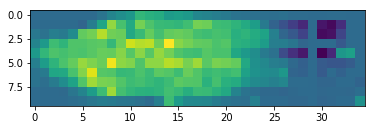

In [87]:
next(chunks)

,duration,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,week_0,week_1,week_2,week_3,...,hour_22,hour_23,start_lon_raw,start_lat_raw,end_lon_raw,end_lat_raw,start_x,start_y,end_x,end_y
429000,220.0,-0.593514,0.432520,2.163505,0.726924,2.266675,0,0,0,0,...,0,1,-73.967914,40.802162,-73.957464,40.811673,1.118189,21.814597,1.780374,24.561955
429001,1416.0,0.227681,0.140130,0.088084,-1.229397,-0.220854,1,0,0,0,...,0,0,-73.974909,40.755201,-74.008307,40.747443,5.231644,13.255969,0.574109,8.222889
429002,690.0,-0.182917,0.960200,0.671054,-0.118238,0.331298,1,0,0,0,...,0,0,-73.955290,40.768392,-73.979429,40.761700,6.998494,17.641689,3.753942,13.824380
429003,976.0,0.455790,-0.159783,0.090780,1.278270,0.938482,1,0,0,0,...,0,0,-73.982084,40.755262,-73.943135,40.777378,4.037120,12.460678,8.001837,20.493529
429004,754.0,0.866388,1.050404,1.002249,-0.605827,-1.125745,0,0,1,0,...,1,0,-73.953132,40.775886,-73.992101,40.724078,6.514511,19.124404,5.879388,6.174396
429005,450.0,-0.365404,-1.068510,-0.423866,-0.449724,0.245398,0,1,0,0,...,0,0,-74.003824,40.743617,-73.988044,40.759482,1.745645,8.092785,2.576871,12.490208
429006,288.0,-0.821624,-0.202377,-1.169119,-0.167528,-1.060991,0,1,0,0,...,0,0,-73.983103,40.726754,-73.980710,40.725750,7.068446,7.627372,7.577257,7.729793
429007,1513.0,0.638278,-0.312603,0.423963,-0.676319,-1.249947,0,0,0,0,...,0,0,-73.985740,40.762801,-73.993933,40.720871,2.585697,13.298224,5.936121,5.437902
429008,242.0,-0.730380,-0.839615,-1.263430,-0.901451,-0.760187,0,0,1,0,...,0,0,-73.998348,40.724620,-73.999784,40.733517,4.784484,5.562892,3.548102,6.874421
429009,208.0,-0.228539,0.375630,0.205023,0.921005,1.092932,0,0,0,1,...,0,0,-73.969275,40.757847,-73.952420,40.781366,5.867227,14.326372,6.017243,20.111428


In [80]:
g = np.zeros((10,35))

In [81]:
g[grid]

IndexError: arrays used as indices must be of integer (or boolean) type

In [78]:
grid

array([[  2.,   0.],
       [  3.,   0.],
       [  4.,   0.],
       [  5.,   0.],
       [  6.,   0.],
       [  7.,   0.],
       [  2.,   1.],
       [  3.,   1.],
       [  4.,   1.],
       [  5.,   1.],
       [  6.,   1.],
       [  7.,   1.],
       [  2.,   2.],
       [  3.,   2.],
       [  4.,   2.],
       [  5.,   2.],
       [  6.,   2.],
       [  7.,   2.],
       [  2.,   3.],
       [  3.,   3.],
       [  4.,   3.],
       [  5.,   3.],
       [  6.,   3.],
       [  7.,   3.],
       [  8.,   3.],
       [  2.,   4.],
       [  3.,   4.],
       [  4.,   4.],
       [  5.,   4.],
       [  6.,   4.],
       [  7.,   4.],
       [  8.,   4.],
       [  9.,   4.],
       [  1.,   5.],
       [  2.,   5.],
       [  3.,   5.],
       [  4.,   5.],
       [  5.,   5.],
       [  6.,   5.],
       [  7.,   5.],
       [  8.,   5.],
       [  9.,   5.],
       [  1.,   6.],
       [  2.,   6.],
       [  3.,   6.],
       [  4.,   6.],
       [  5.,   6.],
       [  6.,

In [85]:
500 - gr * 500

array([[ 500.,  500.,  500.,  500.,  500.,  500.,  500.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,  500.,    0.,    0.,  500.,  500.],
       [ 500.,  500.,  500.,  500.,  500.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,    0.,    0.,    0.,  500.,  500.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  500.,    0.,    0.,    0.,  500.,  500.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   

(-0.5736560024074322,
 11.761119367576924,
 -2.9819052614255535,
 35.76104310768693)

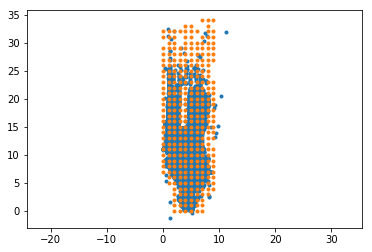

In [45]:
plt.plot(df['start_x']/0.005, df['start_y']/0.005,'.')
plt.plot(grid[:,0]/0.005,grid[:,1]/0.005,'.')
plt.axis('equal')

In [2]:
weight = np.arange(350).reshape(10, 35)